In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.profiler import profile, record_function, ProfilerActivity
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
import json
import seaborn as sns
import time
import itertools
import cProfile
from torch.utils.checkpoint import checkpoint
import torch.nn.functional as F

In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation & Preprocessing

In [107]:
def load_configs(filename):
    with open(f'/content/drive/My Drive/{filename}.json', 'r') as file:
        return json.load(file)

In [108]:
# Plot functions
def plot_last_prices(last_prices, normalized=True):
    plt.figure(figsize=(10, 5))
    plt.plot(last_prices, label='Normalized Prices')
    plt.legend()
    plt.ylabel('Normalized Price' if normalized else 'Price')
    plt.xlabel('Time Index')
    plt.title('Relative Change Rates of Close Prices' if normalized else 'Close Prices')
    plt.show()

def plot_volume(data, title):
    plt.figure(figsize=(10, 5))
    plt.plot(data['datetime'], data['volume'])
    plt.xlabel('Date')
    plt.ylabel('Trade Volume')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def plot_prices_with_ma(data, period, period_labels):
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data['last_price'], label='Last Price')
    for i in range(len(period)):
      t = period[i]
      period_label = period_labels[i]
      plt.plot(data.index, data[f'ma({t})'], label=f'{period_label} MA')
    plt.xlabel('Date')
    plt.ylabel('Last Price')
    plt.title('Prices with Moving Average')
    plt.legend()
    plt.show()

def plot_prices_with_macd(data, short_period, long_period, signal_period):
    for i in range(len(short_period)):
      plt.figure(figsize=(10, 5))
      a = short_period[i]
      b = long_period[i]
      c = signal_period[i]
      plt.plot(data.index, data[f'macd_line({a},{b},{c})'], label=f'MACD')
      plt.plot(data.index, data[f'signal_line({a},{b},{c})'], label=f'Signal')
      plt.plot(data.index, data[f'macd_histogram({a},{b},{c})'], label=f'Histogram')
      plt.xlabel('Date')
      plt.ylabel('Convergence/Divergence')
      plt.title(f"MACD({a},{b},{c})")
      plt.legend()
      plt.show()

In [109]:
# Moving Average (MA)
def moving_average(last_prices, num_periods):
    ma = last_prices.rolling(window=num_periods, min_periods=1).mean()
    # Forward fill the first num_periods-1 NaN values with the first non-NaN value
    ma.ffill(inplace=True)
    return ma

def calculate_ema(data, period):
    alpha = 2 / (period + 1)
    ema = [data.iloc[0]]  # EMA starts with the first data point

    for price in data.iloc[1:]:
        ema.append(alpha * price + (1 - alpha) * ema[-1])

    return pd.Series(ema, index=data.index)

# Moving Average Convergence/Divergence (MACD)
def calculate_macd(data, short_period, long_period, signal_period):
    short_ema = calculate_ema(data, short_period)
    long_ema = calculate_ema(data, long_period)

    macd_line = short_ema - long_ema
    signal_line = calculate_ema(macd_line, signal_period)
    macd_histogram = macd_line - signal_line

    return macd_line, signal_line, macd_histogram

In [110]:
def filter_data_by_intervals(data, intervals):
    # Initialize a mask with False values
    interval_mask = pd.Series([False] * len(data))

    # Iterate over intervals and apply masks
    for start, end in intervals:
        start_time = pd.to_datetime(start).time()
        end_time = pd.to_datetime(end).time()

        # Create masks for start and end times
        start_time_mask = (data['datetime'].dt.time >= start_time)
        end_time_mask = (data['datetime'].dt.time <= end_time)

        # Combine masks based on interval crossing midnight or not
        if start_time <= end_time:
            interval_mask |= (start_time_mask & end_time_mask)
        else:
            interval_mask |= (start_time_mask | end_time_mask)

    # Apply the final mask to filter the data
    data_filtered = data[interval_mask]
    return data_filtered

def assert_time_intervals(df, intervals):
    df.index = pd.to_datetime(df.index)
    times = df.index.time

    time_intervals = [(pd.Timestamp(start).time(), pd.Timestamp(end).time()) for start, end in intervals]

    def is_within_intervals(t):
        return any(start <= t <= end if start <= end else start <= t or t <= end for start, end in time_intervals)

    outside_intervals = ~np.vectorize(is_within_intervals)(times)

    if outside_intervals.any():
        print("There are times outside the specified intervals:")
        print(df[outside_intervals])
    else:
        print("All times are within the specified intervals.")

    assert(not outside_intervals.any())

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def extract_main_contract(data_filtered, window=1000, min_periods=1, quantile=0.80):
    # Compute the rolling mean of volume
    data_filtered['volume_rolling'] = data_filtered['volume'].rolling(window=window, min_periods=min_periods).mean()

    # Calculate the volume threshold based on the quantile
    volume_threshold = data_filtered['volume_rolling'].quantile(quantile)

    # Identify high volume segments
    data_filtered['high_volume'] = data_filtered['volume_rolling'] > volume_threshold

    # Segment identification by cumulative sum of changes in high_volume status
    data_filtered['segment'] = data_filtered['high_volume'].ne(data_filtered['high_volume'].shift()).cumsum()

    # Filter the high volume segments and fill NaN values
    high_volume_segments = data_filtered[data_filtered['high_volume']]
    high_volume_segments['volume'] = high_volume_segments['volume'].ffill()

    # Drop the temporary columns
    high_volume_segments.drop(columns=['high_volume', 'segment', 'volume_rolling'], inplace=True)

    return high_volume_segments


def normalize_prices(data_array, intervals, timestamps, num_steps, input_size, last_price_index=0):
    # Convert timestamps to time objects
    timestamp_times = timestamps.time

    # Create an empty array to collect normalized prices
    normalized_last_price = np.full(len(data_array), np.nan)  # Use NaN to identify unassigned values

    for start, end in intervals:
        start_time = pd.Timestamp(start).time()
        end_time = pd.Timestamp(end).time()

        # Create masks for the interval
        start_mask = timestamp_times >= start_time
        end_mask = timestamp_times <= end_time
        if start_time <= end_time:
            interval_mask = start_mask & end_mask
        else:
            interval_mask = start_mask | end_mask

        # Filter data by interval
        interval_data = data_array[interval_mask]
        clear_gpu_cache()
        if len(interval_data) == 0:
            continue

        num_windows = (len(interval_data) + input_size - 1) // input_size
        windows = np.array_split(interval_data, num_windows)

        # Create array to hold normalized values for the current interval
        interval_normalized_last_price = np.full(len(interval_data), np.nan)

        start_idx = 0
        for window_data in windows:
            if len(window_data) == 0:
                continue

            if start_idx == 0:
                window_first_price = window_data[0, last_price_index]
                values = window_data[:, last_price_index] / window_first_price - 1.0
            else:
                window_last_price = window_data[-1, last_price_index]
                values = window_data[:, last_price_index] / window_last_price - 1.0

            end_idx = start_idx + len(window_data)
            interval_normalized_last_price[start_idx:end_idx] = values
            start_idx = end_idx

        normalized_last_price[interval_mask] = interval_normalized_last_price

    # Set to the data array
    data_array[:, last_price_index] = normalized_last_price

    # Process all outliers - impute with its previous non-outlying value
    postprocess_outliers(data_array)

    # Check for NaN values
    if np.isnan(data_array[:, last_price_index]).any():
        raise ValueError("Data contains NaN values after normalization. Please check the normalization process.")

    return data_array


def postprocess_outliers(data, threshold=0.5):
    outlier_indices = np.where(np.abs(data[:, 0]) > threshold)[0]

    for idx in outlier_indices:
        previous_value_idx = idx - 1
        while data[previous_value_idx, 0] > threshold and previous_value_idx > 0:
            previous_value_idx -= 1
        data[idx, 0] = data[previous_value_idx, 0]

def roll_data(data_array, num_steps, input_size):
    # Roll data to reshape it into the 4D shape (N, num_steps, input_size, # features)
    data_array = [np.array(data_array[i * input_size: (i + 1) * input_size])
                  for i in range(len(data_array) // input_size)]
    data_array = np.stack(data_array)
    return data_array


# Generator function
def data_generator(data_array, indices, num_steps, batch_size, last_price_index=0):
    total_len = len(indices)
    for start_idx in range(0, total_len, batch_size):
        end_idx = min(start_idx + batch_size, total_len)
        batch_indices = indices[start_idx:end_idx]
        X_batch = np.array([data_array[i: i + num_steps] for i in batch_indices])
        y_batch = data_array[batch_indices + num_steps, :, last_price_index]
        yield X_batch, y_batch


# Train-test split function
def train_test_split(data_array, num_steps, input_size, val_split, test_split, last_price_index=0):
    # Calculate the total number of samples
    total_len = len(data_array) - num_steps

    X = np.empty((total_len, num_steps, input_size, data_array.shape[-1] - 1), dtype=np.float32)
    y = np.empty((total_len, num_steps), dtype=np.float32)

    for i in range(total_len):
        X[i] = data_array[i:i + num_steps, :, 1:]  # Exclude the last_price column (column 0)
        y[i] = data_array[i:i + num_steps, :, last_price_index]  # Store the last_price values

    # Check the shapes of X and y
    num_features = data_array.shape[-1] - 1  # Exclude the last_price column
    assert X.shape == (total_len, num_steps, input_size, num_features), f"X shape mismatch: {X.shape}"
    assert y.shape == (total_len, num_steps), f"y shape mismatch: {y.shape}"
    assert len(X) == len(y), "Number of samples in X and y must be equal"

    # Determine the split indices
    test_start = int(total_len * (1 - test_split))
    val_start = int(total_len * (1 - test_split - val_split))

    # Split the data
    X_train, X_val, X_test = X[:val_start], X[val_start:test_start], X[test_start:]
    y_train, y_val, y_test = y[:val_start], y[val_start:test_start], y[test_start:]

    return X_train, y_train, X_val, y_val, X_test, y_test

def normalize_data(data):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    normalized_df = pd.DataFrame(normalized_data, index=data.index, columns=data.columns)
    return normalized_df

class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data, num_steps, last_price_index):
        self.data = data
        self.num_steps = num_steps
        self.last_price_index = last_price_index
        self.num_features = data.shape[-1] - 1  # Exclude the last_price column

    def __len__(self):
        return len(self.data) - self.num_steps

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx + self.num_steps, :, 1:], dtype=torch.float32)  # Exclude the last_price column (column 0)
        y = torch.tensor(self.data[idx:idx + self.num_steps, :, self.last_price_index], dtype=torch.float32)
        return x, y

# Create dataloader instances
def create_dataloader_instances(dataset, val_split, test_split, batch_size, num_workers=2):
    dataset_size = len(dataset)
    test_size = int(test_split * dataset_size)
    val_size = int(val_split * (dataset_size - test_size))
    train_size = dataset_size - val_size - test_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader

# Create forward fill bid custom
def forward_fill_bid_custom(data, price_cols):
    # Forward fill NaN values across rows for specified columns
    data[price_cols] = data[price_cols].ffill(axis=1)

    # Forward fill NaN values across columns for specified columns
    data[price_cols] = data[price_cols].ffill(axis=0)

    return data

def clear_gpu_cache():
    torch.cuda.empty_cache()


# Create sequences based on the extended_segment
def create_sequences(extended_segment, num_steps, input_size, normalize, val_split=0.1, test_split=0.1, batch_size=64):
    # Ensure no NaN values
    assert(np.isnan(extended_segment).sum().sum() == 0)

    # Setup
    timestamps = extended_segment.index
    extended_segment = extended_segment.to_numpy()
    last_price_index = 0

    # Prevent a division by 0 by imputing 0s to a very small number
    extended_segment[:, last_price_index] = np.where(extended_segment[:, last_price_index] == 0, 1e-6, extended_segment[:, last_price_index])

    # Plot the prices before normalization
    plot_last_prices(extended_segment[:, last_price_index], normalized=False)

    # Normalize prices - retrieve relative change rates
    if normalize:
        extended_segment = normalize_prices(extended_segment, intervals, timestamps, num_steps, input_size, last_price_index)

    clear_gpu_cache()

    # Plot the prices after normalization
    plot_last_prices(extended_segment[:, last_price_index])

    # Roll data for RNN
    extended_segment = roll_data(extended_segment, num_steps, input_size)
    clear_gpu_cache()

    # Create dataset and dataloader instances
    dataset = TimeSeriesDataset(extended_segment, num_steps, last_price_index)
    clear_gpu_cache()
    train_loader, val_loader, test_loader = create_dataloader_instances(dataset, val_split=val_split, test_split=test_split, batch_size=batch_size)
    clear_gpu_cache()

    # Remove all rows with exceptionally small bid ask spread
    extended_segment = extended_segment[:, ]

    return extended_segment, train_loader, val_loader, test_loader, dataset.num_features


def add_derived_features(extended_segment):
    # Forward fill nan values in bid_prices (NOTE: This may not reflect the changes in market!)
    bid_price_cols = ['bid_price1', 'bid_price2', 'bid_price3', 'bid_price4', 'bid_price5']
    ask_price_cols = ['ask_price1', 'ask_price2', 'ask_price3', 'ask_price4', 'ask_price5']
    extended_segment = forward_fill_bid_custom(extended_segment, bid_price_cols)

    # Bid & Ask Volumes
    bid_volume_cols = ['bid_volume1', 'bid_volume2', 'bid_volume3', 'bid_volume4', 'bid_volume5']
    ask_volume_cols = ['ask_volume1', 'ask_volume2', 'ask_volume3', 'ask_volume4', 'ask_volume5']

    # Calculate Bid-Ask Spread
    extended_segment['bid_ask_spread'] = extended_segment['ask_price1'] - extended_segment['bid_price1']

    # Calculate Market Depth (total bid and ask volumes)
    extended_segment['total_bid_volume'] = extended_segment[bid_volume_cols].sum(axis=1)
    extended_segment['total_ask_volume'] = extended_segment[ask_volume_cols].sum(axis=1)

    # Calculate Order Imbalance Ratio
    extended_segment['order_imbalance_ratio'] = (extended_segment['total_bid_volume'] - extended_segment['total_ask_volume']) / (extended_segment['total_bid_volume'] + extended_segment['total_ask_volume'])

    # Calculate Volume Order Imbalance
    delta_bid_vol = extended_segment[bid_volume_cols].diff().fillna(0)
    delta_ask_vol = extended_segment[ask_volume_cols].diff().fillna(0)
    delta_bid_price = extended_segment[bid_price_cols].diff().fillna(0)
    delta_ask_price = extended_segment[ask_price_cols].diff().fillna(0)

    for i in range(1, 6):
        bid_vol_col = f'bid_volume{i}'
        ask_vol_col = f'ask_volume{i}'
        bid_price_col = f'bid_price{i}'
        ask_price_col = f'ask_price{i}'

        # Clip delta_bid_vol to bid_volume on a rise
        delta_bid_vol[bid_vol_col] = np.where(delta_bid_price[bid_price_col] > 0,
                                              np.minimum(delta_bid_vol[bid_vol_col], extended_segment[bid_vol_col]),
                                              delta_bid_vol[bid_vol_col])

        # Clip delta_ask_vol to ask_volume on a fall
        delta_ask_vol[ask_vol_col] = np.where(delta_ask_price[ask_price_col] < 0,
                                              np.minimum(delta_ask_vol[ask_vol_col], extended_segment[ask_vol_col]),
                                              delta_ask_vol[ask_vol_col])

    extended_segment['volume_order_imbalance'] = delta_bid_vol.sum(axis=1) - delta_ask_vol.sum(axis=1)

    # Calculate Mid-Price Basis
    extended_segment['mid_price'] = (extended_segment['bid_price1'] + extended_segment['ask_price1']) / 2

    # Calculate average trade price if it doesn't exist
    if 'average_trade_price' not in extended_segment.columns:
        extended_segment['average_trade_price'] = np.where(
            extended_segment['volume'].diff() != 0,
            (extended_segment['amount'].diff() / extended_segment['volume'].diff()).fillna(0),
            extended_segment['mid_price']
        )
    else:
        extended_segment['average_trade_price'] = np.where(
            extended_segment['volume'].diff() != 0,
            (extended_segment['amount'].diff() / extended_segment['volume'].diff()).fillna(0),
            extended_segment['average_trade_price'].shift(1).fillna(0)
        )

    extended_segment['mid_price_basis'] = extended_segment['average_trade_price'] - extended_segment['mid_price']

    # Drop intermediary derived feature columns
    intermediary_columns = [
        'total_bid_volume', 'total_ask_volume', 'mid_price', 'average_trade_price'
    ]
    extended_segment = extended_segment.drop(columns=intermediary_columns)

    # Remove all rows with exceptionally small bid ask spread
    # print('ratio with small bid ask spread:', len(extended_segment[extended_segment['bid_ask_spread'] < 0.00001]) / len(extended_segment))
    # extended_segment = extended_segment.apply(lambda row: extended_segment['bid_ask_spread'] >= 0.00001)
    # print(extended_segment.columns)

    # Ensure there are no NaN values
    assert not extended_segment.isnull().values.any(), "There are NaN values in the derived features"
    assert(np.isnan(extended_segment).sum().sum() == 0)

    # # Ensure there are no INF values
    # assert not np.isinf(extended_segment).values.any(), "DataFrame contains infinite values"
    # assert(np.isinf(extended_segment).sum().sum() == 0)

# def add_derived_features(extended_segment):
#     # Forward fill nan values in bid_prices (NOTE: This may not reflect the changes in market!)
#     bid_price_cols = ['bid_price1', 'bid_price2', 'bid_price3', 'bid_price4', 'bid_price5']
#     extended_segment = forward_fill_bid_custom(extended_segment, bid_price_cols)

#     # Bid & Ask Volumes
#     bid_volume_cols = ['bid_volume1', 'bid_volume2', 'bid_volume3', 'bid_volume4', 'bid_volume5']
#     ask_volume_cols = ['ask_volume1', 'ask_volume2', 'ask_volume3', 'ask_volume4', 'ask_volume5']

#     # Calculate Bid-Ask Spread
#     extended_segment['bid_ask_spread'] = extended_segment['ask_price1'] - extended_segment['bid_price1']

#     # Calculate Market Depth (total bid and ask volumes)
#     extended_segment['total_bid_volume'] = extended_segment[bid_volume_cols].sum(axis=1)
#     extended_segment['total_ask_volume'] = extended_segment[ask_volume_cols].sum(axis=1)

#     # Calculate Order Imbalance
#     extended_segment['order_imbalance'] = extended_segment['total_bid_volume'] - extended_segment['total_ask_volume']


def add_factors(extended_segment, short_period, long_period, signal_period, period):
    # Compute Factors: MA & MACD
    for i in range(len(period)):
      # Calculate MA
      t = period[i]
      extended_segment[f'ma({t})'] = moving_average(extended_segment['last_price'], t)
      extended_segment[f'ma({t})'] = extended_segment[f'ma({t})'].fillna(method='ffill')

      # Calculate MACD
      a = short_period[i]
      b = long_period[i]
      c = signal_period[i]
      macd_line, signal_line, macd_histogram = calculate_macd(extended_segment['last_price'], a, b, c)
      extended_segment[f'macd_line({a},{b},{c})'] = macd_line
      extended_segment[f'signal_line({a},{b},{c})'] = signal_line
      extended_segment[f'macd_histogram({a},{b},{c})'] = macd_histogram

    print(extended_segment.columns)
    # print(pd.isna(extended_segment).sum())

All times are within the specified intervals.


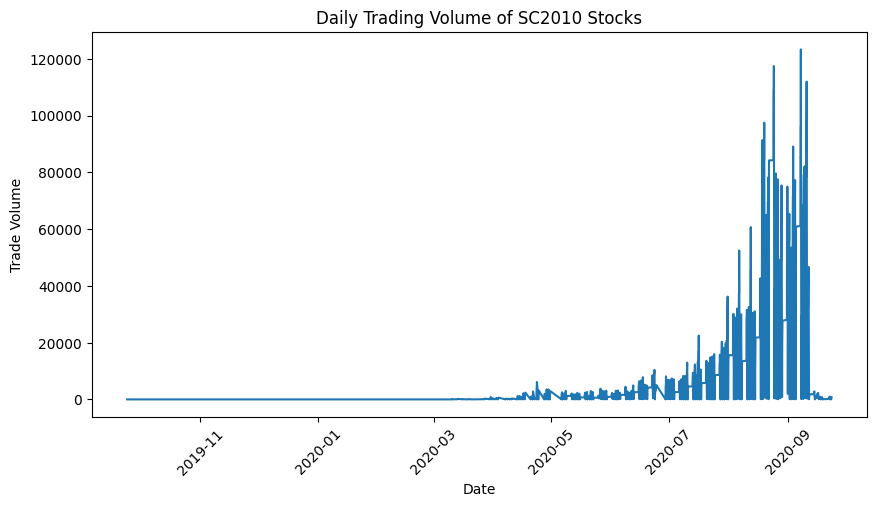

<ipython-input-110-bb17dd10a373>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['volume_rolling'] = data_filtered['volume'].rolling(window=window, min_periods=min_periods).mean()
<ipython-input-110-bb17dd10a373>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['high_volume'] = data_filtered['volume_rolling'] > volume_threshold
<ipython-input-110-bb17dd10a373>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

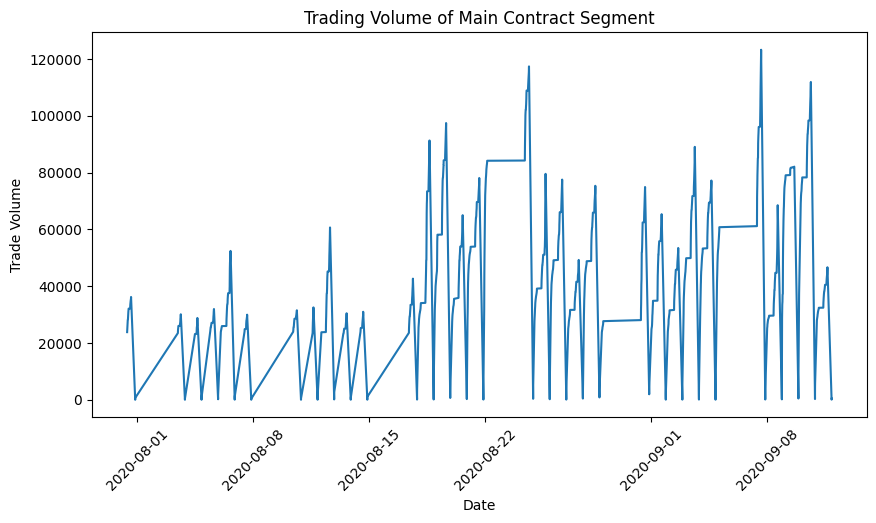

All times are within the specified intervals.


<ipython-input-110-bb17dd10a373>:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[price_cols] = data[price_cols].ffill(axis=1)
<ipython-input-110-bb17dd10a373>:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[price_cols] = data[price_cols].ffill(axis=0)
<ipython-input-110-bb17dd10a373>:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

Index(['last_price', 'highest', 'lowest', 'bid_price1', 'bid_volume1',
       'bid_price2', 'bid_volume2', 'bid_price3', 'bid_volume3', 'bid_price4',
       'bid_volume4', 'bid_price5', 'bid_volume5', 'ask_price1', 'ask_volume1',
       'ask_price2', 'ask_volume2', 'ask_price3', 'ask_volume3', 'ask_price4',
       'ask_volume4', 'ask_price5', 'ask_volume5', 'volume', 'amount',
       'open_interest', 'bid_ask_spread', 'total_bid_volume',
       'total_ask_volume', 'order_imbalance_ratio', 'volume_order_imbalance',
       'mid_price', 'average_trade_price', 'mid_price_basis', 'ma(5)',
       'macd_line(5,15,10)', 'signal_line(5,15,10)', 'macd_histogram(5,15,10)',
       'ma(10)', 'macd_line(10,20,20)', 'signal_line(10,20,20)',
       'macd_histogram(10,20,20)', 'ma(15)', 'macd_line(15,25,30)',
       'signal_line(15,25,30)', 'macd_histogram(15,25,30)', 'ma(20)',
       'macd_line(20,30,40)', 'signal_line(20,30,40)',
       'macd_histogram(20,30,40)'],
      dtype='object')


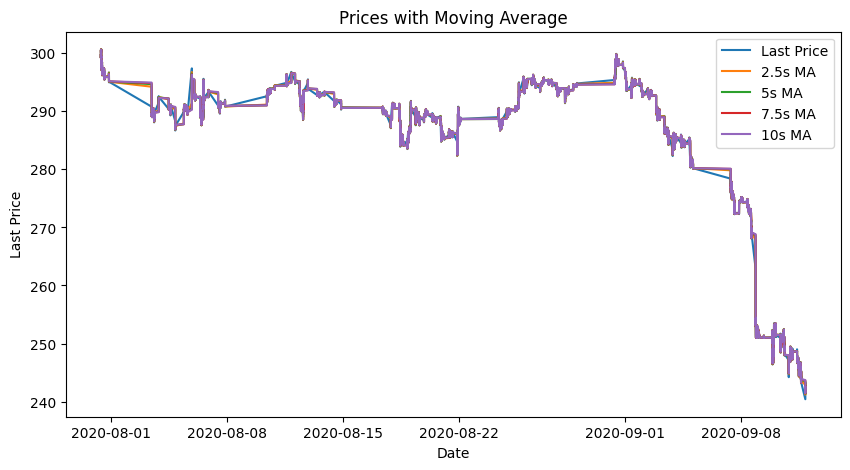

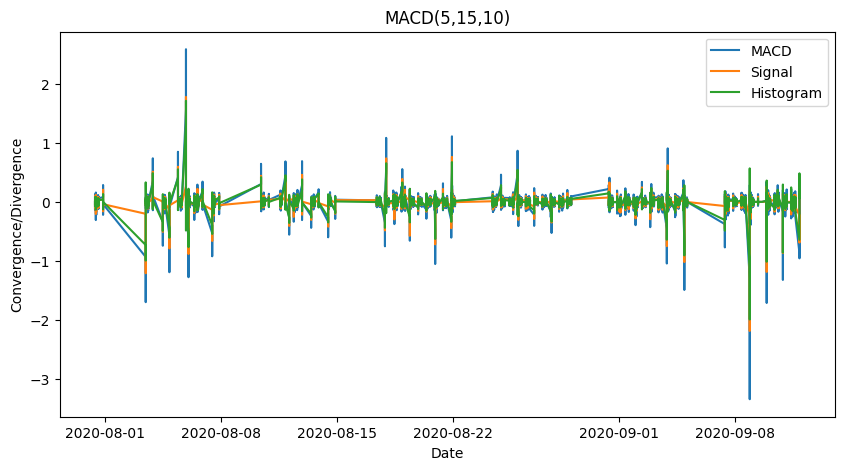

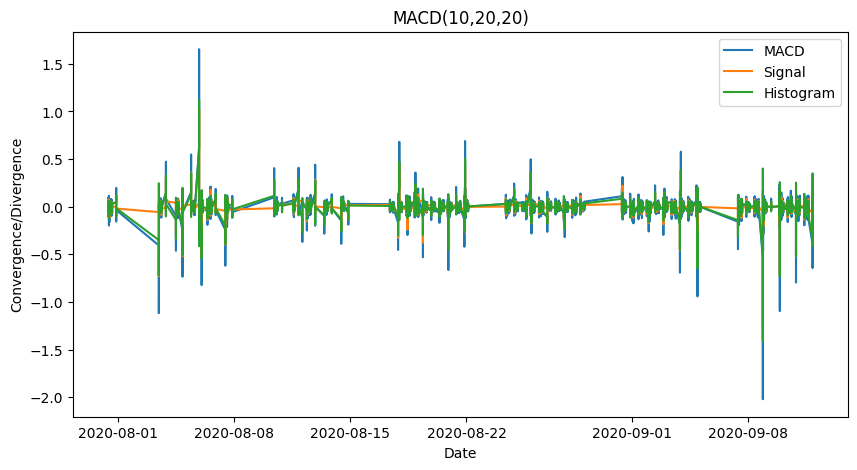

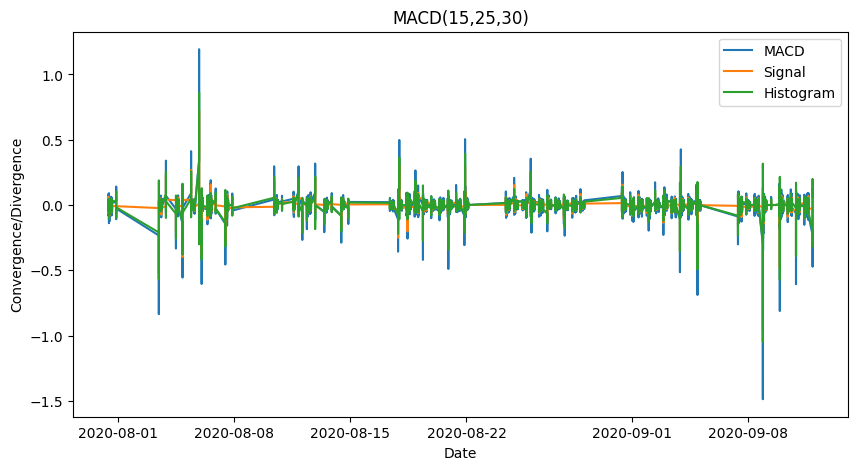

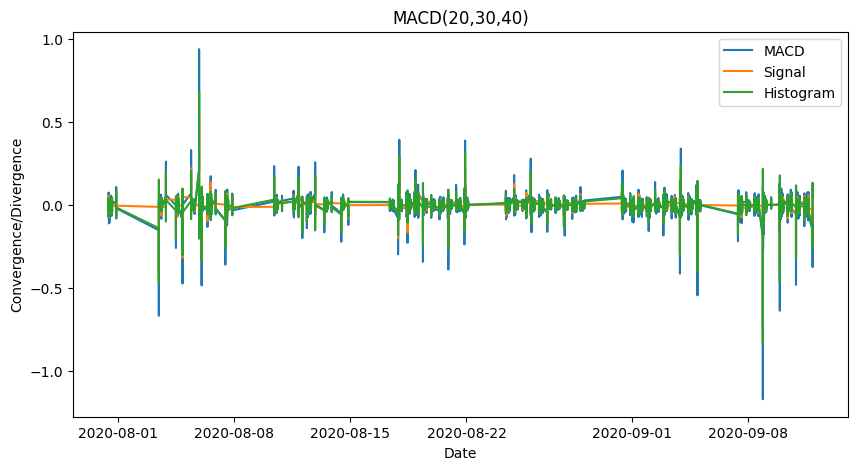

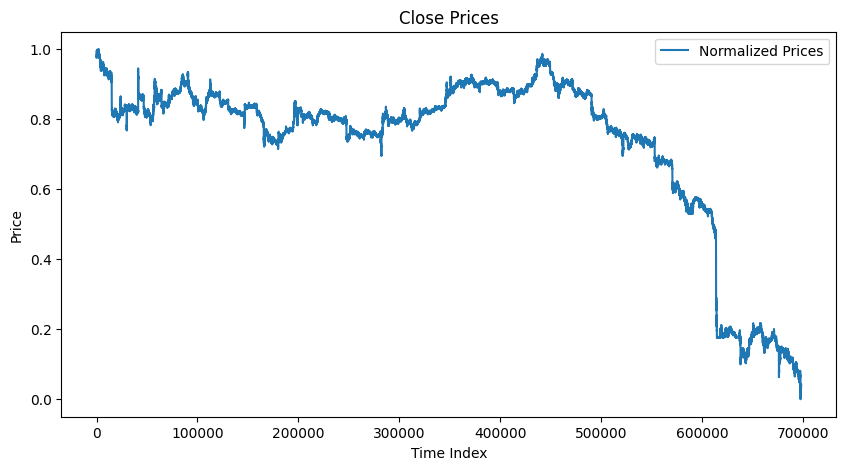

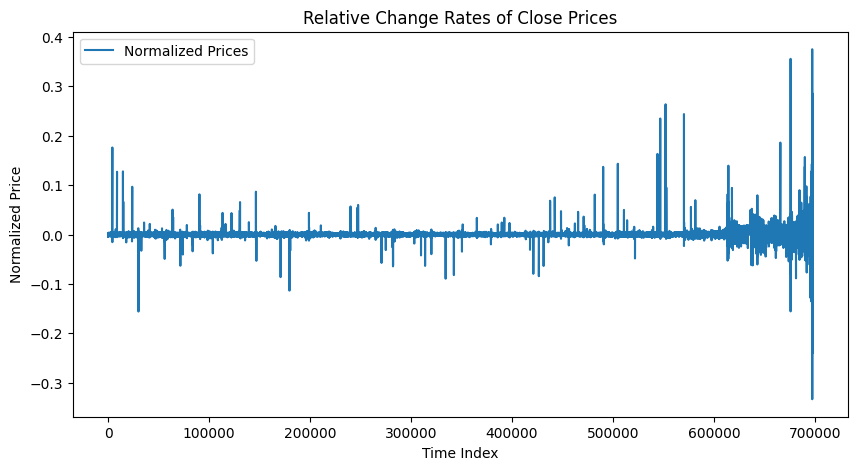

In [111]:
# Params
dataset_filename = 'INE.sc2010'
intervals = [
    ('21:00:00', '02:30:00'),
    ('09:00:00', '10:15:00'),
    ('10:30:00', '11:30:00'),
    ('13:30:00', '15:00:00')
]
configs_filename = 'configs'

# Load configs file
configs = load_configs(configs_filename)
clear_gpu_cache()

# Read data
# data = pd.read_csv('data/' + dataset_filename + '.csv')
data = pd.read_csv(f'/content/drive/My Drive/{dataset_filename}.csv')
data['datetime'] = pd.to_datetime(data['datetime'])

# Set seed
set_seed(42)

with cProfile.Profile() as pr:
    # Only include data within the specified intervals
    data_filtered = filter_data_by_intervals(data, intervals)
    # pr.print_stats()

    # Make sure there are no values outside the given time intervals
    assert_time_intervals(data_filtered, intervals)
    # pr.print_stats()

    # Plot trading volume data
    plot_volume(data_filtered, 'Daily Trading Volume of SC2010 Stocks')

    # Extract the main contract
    # data_filtered = data_filtered.copy() # Avoid SettingWithCopyWarning
    # pr.print_stats()
    data_filtered.iloc[:, 1:] = data_filtered.iloc[:, 1:].astype(np.float32)
    # pr.print_stats()
    extended_segment = extract_main_contract(data_filtered)
    # pr.print_stats()

    # Plot main contract segment
    plot_volume(extended_segment, 'Trading Volume of Main Contract Segment')
    # pr.print_stats()

    # Set index of the resulting dataframe
    extended_segment.set_index('datetime', inplace=True)
    # pr.print_stats()

    # Make sure there are no values outside the given time intervals
    assert_time_intervals(extended_segment, intervals)
    # pr.print_stats()

    # Extract needed hyperparams
    input_size = configs['input_size']
    num_steps = configs['num_steps']
    normalize = configs['normalize']
    batch_size = configs['batch_size']

    # Add derived features
    add_derived_features(extended_segment)

    # Add factors
    period_labels = np.array(['2.5s', '5s', '7.5s', '10s'])
    period = np.array([5, 10, 15, 20])
    short_period = period
    long_period = period + 10
    signal_period = 2 * period

    add_factors(extended_segment, short_period, long_period, signal_period, period)
    # pr.print_stats()

    # Plot closing prices with factors
    plot_prices_with_ma(extended_segment, period, period_labels)
    plot_prices_with_macd(extended_segment, short_period, long_period, signal_period)

    # Normalize data
    extended_segment = normalize_data(extended_segment)
    # pr.print_stats()
    assert(extended_segment.isna().sum().sum() == 0)

    # Create sequences based on the extended_segment
    extended_segment, train_loader, val_loader, test_loader, num_features = create_sequences(extended_segment, num_steps, input_size, normalize, val_split=0.1, test_split=0.1, batch_size=batch_size)

In [113]:
# for X_batch, y_batch in train_loader:
#     assert(X_batch.shape == (configs['batch_size'], configs['num_steps'], configs['input_size'], num_features))
#     assert(y_batch.shape == (configs['batch_size'], configs['num_steps'], configs['input_size']))

In [114]:
# for X_batch, y_batch in val_loader:
#     assert(X_batch.shape == (configs['batch_size'], configs['num_steps'], configs['input_size'], num_features))
#     assert(y_batch.shape == (configs['batch_size'], configs['num_steps'], configs['input_size']))

In [115]:
# for X_batch, y_batch in test_loader:
#     assert(X_batch.shape == (configs['batch_size'], configs['num_steps'], configs['input_size'], num_features))
#     assert(y_batch.shape == (configs['batch_size'], configs['num_steps'], configs['input_size']))

## RNN Model Definition

In [117]:
configs

{'num_steps': 20,
 'input_size': 10,
 'normalize': True,
 'batch_size': 1000,
 'lstm': {'lstm_units': 250,
  'lstm_layers': 5,
  'dropout_rate': 0.1,
  'dense_units': 25,
  'init_learning_rate': 0.001,
  'learning_rate_decay': 0.99,
  'init_epochs': 5,
  'max_epochs': 50,
  'use_early_stop': True,
  'early_stop_patience': 5,
  'pretrain': True,
  'num_models': 5},
 'gru': {'gru_units': 250,
  'gru_layers': 4,
  'dropout_rate': 0.1,
  'dense_units': 25,
  'init_learning_rate': 0.001,
  'learning_rate_decay': 0.99,
  'init_epochs': 5,
  'max_epochs': 50,
  'use_early_stop': True,
  'early_stop_patience': 5,
  'pretrain': True,
  'num_models': 5}}

In [116]:
def convert_to_labels(val, flat_gap=0.01):
    return 2 if val > flat_gap else 0 if val < -flat_gap else 1

In [118]:
def classification_accuracy(y_pred, y_true):
    y_pred_labels = torch.tensor([convert_to_labels(y) for y in torch.flatten(y_pred)])
    y_true_labels = torch.tensor([convert_to_labels(y) for y in torch.flatten(y_true)])
    # labels = np.vectorize(convert_to_labels)
    return torch.sum(y_pred_labels == y_true_labels) / len(y_true_labels)

In [119]:
# RNN Model (LSTM or GRU)
class RNNModel(nn.Module):
    def __init__(self, rnn_type='lstm', num_steps=20, input_size=10, hidden_units=250, num_layers=5, dropout_rate=0.1, dense_units=25):
        super(RNNModel, self).__init__()
        self.rnn_type = rnn_type
        if rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size * num_features, hidden_units, num_layers, dropout=dropout_rate, batch_first=True)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(input_size * num_features, hidden_units, num_layers, dropout=dropout_rate, batch_first=True)
        else:
            raise ValueError(f"Unsupported RNN type: {rnn_type}")
        self.fc = nn.Linear(hidden_units, dense_units)
        self.out = nn.Linear(dense_units, input_size * num_steps)

    def forward(self, x):
        # Reshape x from 4D into 3D
        batch_size, num_steps, input_size, num_features = x.shape
        x = torch.reshape(x, (batch_size, num_steps, input_size * num_features))

        # Perform forward-feed through layers
        rnn_out, _ = self.rnn(x)
        dense_out = self.fc(rnn_out[:, -1, :])
        out = self.out(dense_out)

        # Reshape out from 2D into 3D
        out = torch.reshape(out, (out.shape[0], num_steps, input_size))

        return out

In [120]:
def train_model(model, train_loader, val_loader, config, device, print_freq=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config['init_learning_rate'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=config['learning_rate_decay'])

    early_stop_patience = config['early_stop_patience']
    best_val_loss = float('inf')
    patience = 0

    for epoch in tqdm(range(config['max_epochs']), position=0, leave=True):
        model.train()
        train_loss = 0.0

        for i, (x_batch, y_batch) in tqdm(enumerate(train_loader), position=0, leave=True):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            print('Training classification:', classification_accuracy(y_pred, y_batch).item())

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, (x_batch, y_batch) in tqdm(enumerate(val_loader), position=0, leave=True):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                y_pred = model(x_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()

                print('Validation classification:', classification_accuracy(y_pred, y_batch).item())


        print(f"Epoch {epoch+1}/{config['max_epochs']}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}")

        if config['use_early_stop']:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience = 0
            else:
                patience += 1
                if patience >= early_stop_patience:
                    print("Early stopping triggered.")
                    break

        scheduler.step()

        return model

In [121]:
def load_model(model, rnn_type, device):
    model_path = f'/content/drive/My Drive/SC2010_{rnn_type}_model.pth'
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model

In [122]:
def train_or_load_model(configs, train_loader, val_loader, rnn_type, device):
    if configs[rnn_type]['pretrain']:
        # Define model & load into device
        model = RNNModel(rnn_type=rnn_type, num_steps=configs['num_steps'], input_size=configs['input_size'], hidden_units=configs[rnn_type][f'{rnn_type}_units'], num_layers=configs[rnn_type][f'{rnn_type}_layers'], dropout_rate=configs[rnn_type]['dropout_rate'], dense_units=configs[rnn_type]['dense_units'])
        model.to(device)

        # Train the model
        model = train_model(model, train_loader, val_loader, configs[rnn_type], device)

        # Save model
        torch.save(model.state_dict(), f'/content/drive/MyDrive/{rnn_type}_model.pth')
    else:
        # Load the model from a pre-saved file
        model = load_model(model, rnn_type, device)

    return model

In [123]:
# Evaluate the model
def evaluate_model(model, test_loader, device):
    # Set the model to evaluation mode
    model.eval()

    test_loss = 0.0
    test_accuracy = 0.0

    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Iterate over test set data
        for i, (x_batch, y_batch) in tqdm(enumerate(test_loader), position=0, leave=True):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            loss = nn.MSELoss()(y_pred, y_batch)
            test_loss += loss.item()

            test_accuracy += classification_accuracy(y_pred, y_batch).item()

    test_loss = test_loss / len(test_loader)
    test_accuracy = test_accuracy / len(test_loader)

    print("Test Loss:", test_loss)
    print('Test classification:', test_accuracy)

In [124]:
# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LSTM Training + Evaluation Results:

In [125]:
rnn_type = 'lstm'

# Training
model = train_or_load_model(configs, train_loader, val_loader, rnn_type, device)

# Evaluation
evaluate_model(model, test_loader, device)

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Training classification: 0.05367499962449074
Training classification: 0.08772499859333038
Training classification: 0.06383000314235687
Training classification: 0.09854000061750412
Training classification: 0.06569500267505646
Training classification: 0.08195500075817108
Training classification: 0.0878949984908104
Training classification: 0.10152000188827515
Training classification: 0.10797499865293503
Training classification: 0.1264050006866455
Training classification: 0.14258499443531036
Training classification: 0.1180500015616417
Training classification: 0.1520950049161911
Training classification: 0.16967499256134033
Training classification: 0.1639699935913086
Training classification: 0.17987500131130219
Training classification: 0.2084449976682663
Training classification: 0.22879000008106232
Training classification: 0.2313999980688095
Training classification: 0.19632500410079956
Training classification: 0.20488999783992767
Training classification: 0.20975500345230103
Training classifi

0it [00:00, ?it/s]

Validation classification: 0.8452950119972229
Validation classification: 0.8461599946022034
Validation classification: 0.8463850021362305
Validation classification: 0.8466050028800964
Validation classification: 0.848924994468689
Validation classification: 0.8494799733161926
Validation classification: 0.8406654596328735
Epoch 1/50, Train Loss: 0.003729954080067967, Val Loss: 0.000122746050432657


0it [00:00, ?it/s]

Test Loss: 0.00011784660039536123
Test classification: 0.8477099282400948


GRU Training + Evaluation Results:

In [126]:
rnn_type = 'gru'

# Training
model = train_or_load_model(configs, train_loader, val_loader, rnn_type, device)

# Evaluation
evaluate_model(model, test_loader, device)

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Training classification: 0.07436999678611755
Training classification: 0.07506000250577927
Training classification: 0.08713000267744064
Training classification: 0.07992000132799149
Training classification: 0.07376500219106674
Training classification: 0.1013299971818924
Training classification: 0.1082800030708313
Training classification: 0.09069500118494034
Training classification: 0.11957000195980072
Training classification: 0.12650999426841736
Training classification: 0.11968500167131424
Training classification: 0.12594999372959137
Training classification: 0.13270500302314758
Training classification: 0.13087999820709229
Training classification: 0.14042499661445618
Training classification: 0.1599850058555603
Training classification: 0.1775750070810318
Training classification: 0.19850000739097595
Training classification: 0.2147749960422516
Training classification: 0.23944999277591705
Training classification: 0.25012001395225525
Training classification: 0.26153498888015747
Training classi

0it [00:00, ?it/s]

Validation classification: 0.867110013961792
Validation classification: 0.867995023727417
Validation classification: 0.8673099875450134
Validation classification: 0.8674150109291077
Validation classification: 0.8697350025177002
Validation classification: 0.8701549768447876
Validation classification: 0.8622302412986755
Epoch 1/50, Train Loss: 0.00317807682062777, Val Loss: 8.155091511850645e-05


0it [00:00, ?it/s]

Test Loss: 7.66741660689669e-05
Test classification: 0.8691228968756539
